In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import time
import os
from dotenv import load_dotenv
os.environ["USE_PYGEOS"] = "0"
import napari_sparrow as nas
from spatialdata import read_zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample 
import scanpy as sc
import seaborn as sns
import anndata as ad
%run own_and_modified_functions.ipynb
warnings.simplefilter(action='ignore')

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data'

In [3]:
anndataA11_all = sc.read(OUTPUT_DIR + '/' + 'A1-1/anndataNucA11_all.h5ad')
anndataA12_all = sc.read(OUTPUT_DIR + '/' + 'A1-2/anndataNucA12_all.h5ad')
anndataC2_all = sc.read(OUTPUT_DIR + '/' + 'C2/anndataNucC2_all.h5ad') 
anndataD21_all = sc.read(OUTPUT_DIR + '/' + 'D2-1/anndataNucD21_all.h5ad')

In [4]:
# Give Leiden clusters unique numbers over all samples
n_leiden_A11 = len(np.unique(anndataA11_all.obs['leiden']))
n_leiden_A12 = len(np.unique(anndataA12_all.obs['leiden']))
n_leiden_C2 = len(np.unique(anndataC2_all.obs['leiden']))
n_leiden_D21 = len(np.unique(anndataD21_all.obs['leiden']))
anndataA11_all.obs['leiden'] = anndataA11_all.obs['leiden'].astype(int)
anndataA12_all.obs['leiden'] = anndataA12_all.obs['leiden'].astype(int) + n_leiden_A11
anndataC2_all.obs['leiden'] = anndataC2_all.obs['leiden'].astype(int) + n_leiden_A11 + n_leiden_A12
anndataD21_all.obs['leiden'] = anndataD21_all.obs['leiden'].astype(int) + n_leiden_A11 + n_leiden_A12 + n_leiden_C2
# reset to string
anndataA11_all.obs['leiden'] = anndataA11_all.obs['leiden'].astype(str)
anndataA12_all.obs['leiden'] = anndataA12_all.obs['leiden'].astype(str)
anndataC2_all.obs['leiden'] = anndataC2_all.obs['leiden'].astype(str)
anndataD21_all.obs['leiden'] = anndataD21_all.obs['leiden'].astype(str)
# make categorical
anndataA11_all.obs['leiden'] = anndataA11_all.obs['leiden'].astype('category')
anndataA12_all.obs['leiden'] = anndataA12_all.obs['leiden'].astype('category')
anndataC2_all.obs['leiden'] = anndataC2_all.obs['leiden'].astype('category')
anndataD21_all.obs['leiden'] = anndataD21_all.obs['leiden'].astype('category')

In [5]:
# concatenate all anndata objects
anndata_samples_together = anndataA11_all.concatenate(anndataA12_all, anndataC2_all, anndataD21_all)

In [6]:
print(anndataA11_all.obs.shape)
print(anndataA12_all.obs.shape)
print(anndataC2_all.obs.shape)
print(anndataD21_all.obs.shape)
print(anndata_samples_together.obs.shape) # batch 0 = A1-1, batch 1 = A1-2, batch 2 = C2, batch 3 = D2-1

(11283, 96)
(8695, 96)
(27133, 96)
(12519, 96)
(59630, 97)


In [7]:
anndata_samples_together.obs.columns

Index(['region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes',
       'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'leiden',
       'portal_vein_EC45', 'LSEC45', 'LSEC Portal', 'LSEC Central',
       'central_vein_EC45', 'stellateAll', 'stellate PeriPortal',
       'stellate PeriCentral', 'FibroblastAll', 'fibroblastPortal',
       'FibroblastsCentral', 'VSMC', 'capsular_fibroblasts45',
       'Mesothelial cells', 'Hepatocytes', 'HepatocytesPortal',
       'HepatocytesCentral', 'Cholangiocytes', 'cDC2s', 'Mig. cDCs',
       'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs',
       'B cells', 'cDC1s', 'Kupffer cells', 'Capsule and Central Vein Mac',
       'Portal LAM macrophages', 'Monocytes', 'LECs',
       'cleanliness_score_genes_original_BasicMartin_12',
       'annotation_score_genes_original_BasicMartin_12', 'annotationSave',
       'Hep', 'score_celltype_own_score_ge

In [8]:
annotation = 'annotation_own_score_genes_Atlas_Scores_12'
path_mg = OUTPUT_DIR + '/' + 'AtlasSecondLevelScores.csv'

Meso
[]
Fibr
[(31, 0.81, 118), (67, 0.58, 89), (166, 0.75, 83), (241, 0.64, 25), (296, 0.78, 201), (423, 0.51, 138), (436, 0.73, 127)]
Hepa
[(2, 0.98, 164), (5, 1.0, 148), (7, 0.99, 141), (9, 1.0, 139), (11, 0.98, 133), (12, 0.98, 133), (14, 0.97, 132), (16, 1.0, 131), (17, 0.99, 130), (18, 0.96, 130), (20, 1.0, 127), (21, 0.99, 125), (23, 0.69, 124), (24, 0.99, 123), (26, 0.97, 122), (28, 1.0, 120), (29, 0.99, 119), (32, 1.0, 118), (34, 0.99, 117), (35, 0.98, 115), (38, 1.0, 113), (39, 1.0, 110), (40, 0.98, 110), (41, 1.0, 108), (43, 0.78, 106), (44, 0.99, 106), (46, 0.98, 106), (47, 0.87, 103), (48, 0.99, 102), (49, 0.83, 102), (50, 0.99, 101), (51, 1.0, 101), (52, 1.0, 100), (53, 1.0, 100), (54, 0.98, 100), (55, 1.0, 99), (57, 1.0, 95), (58, 1.0, 94), (60, 0.98, 92), (61, 0.97, 92), (62, 0.99, 91), (63, 1.0, 91), (65, 1.0, 89), (66, 0.87, 89), (69, 0.99, 85), (70, 1.0, 82), (71, 1.0, 82), (72, 1.0, 81), (73, 0.99, 80), (74, 0.75, 80), (75, 0.94, 80), (76, 0.99, 79), (78, 0.85, 78), 

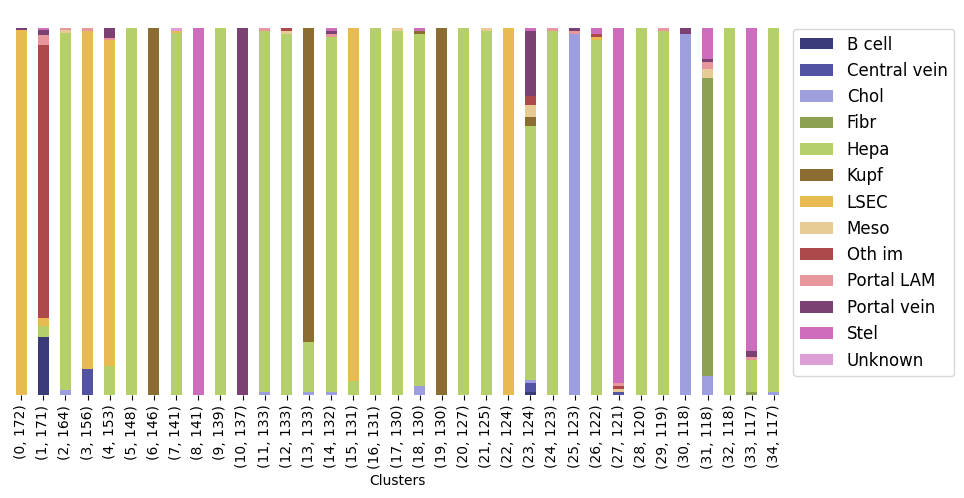

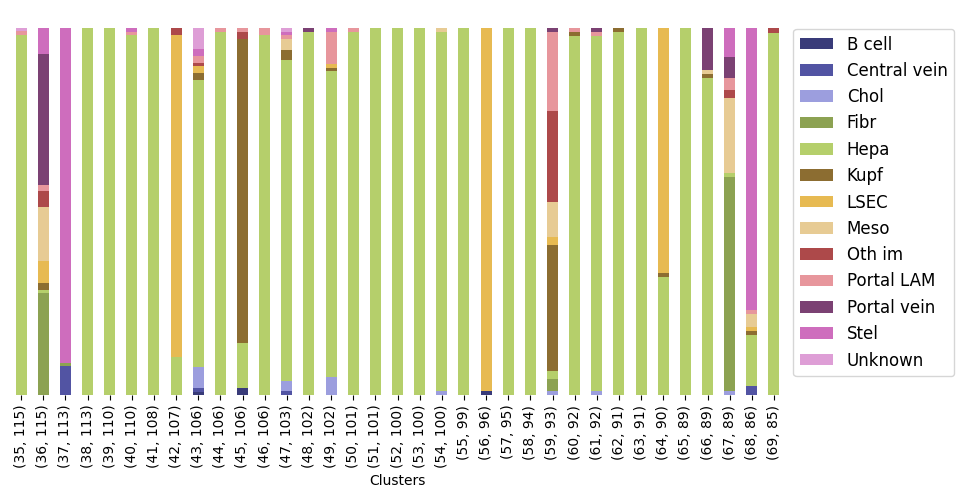

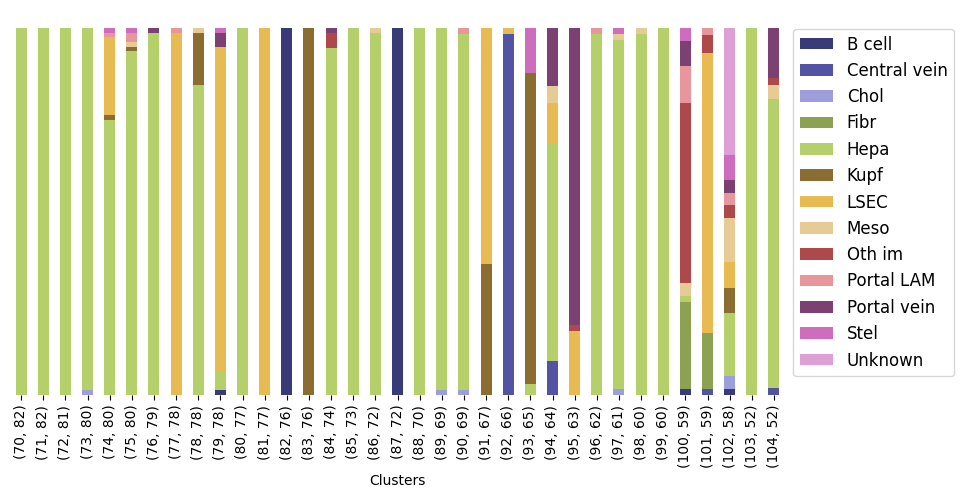

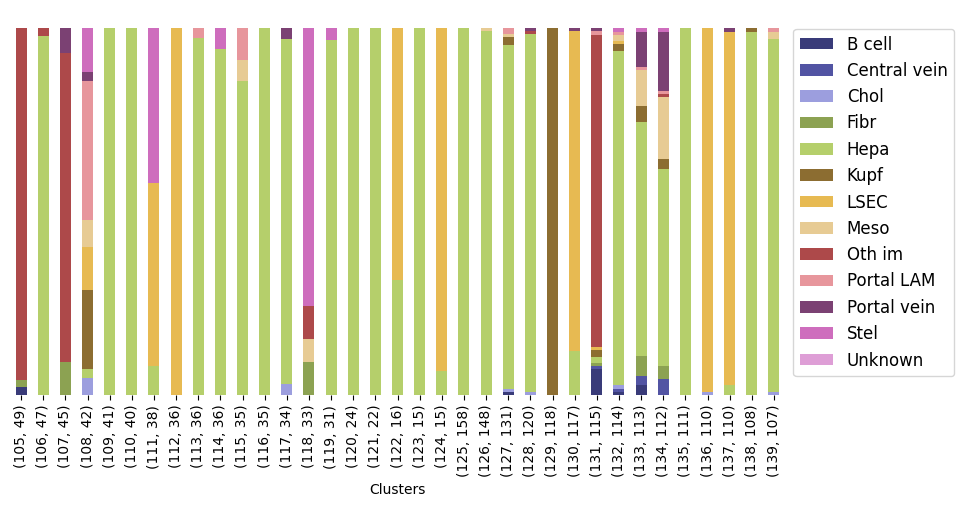

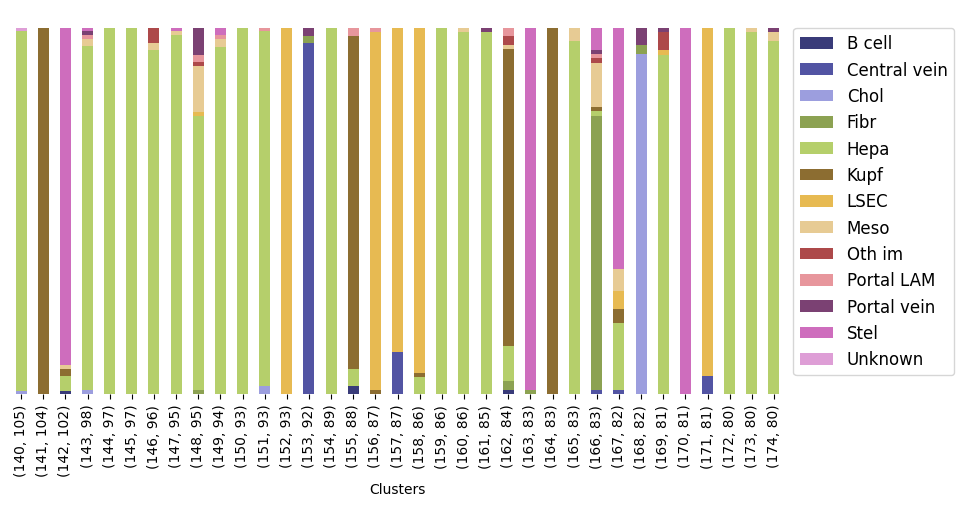

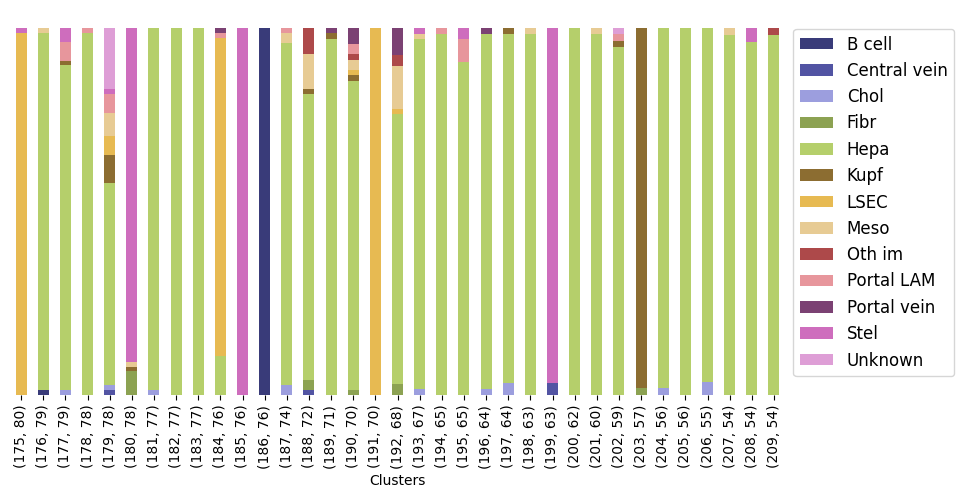

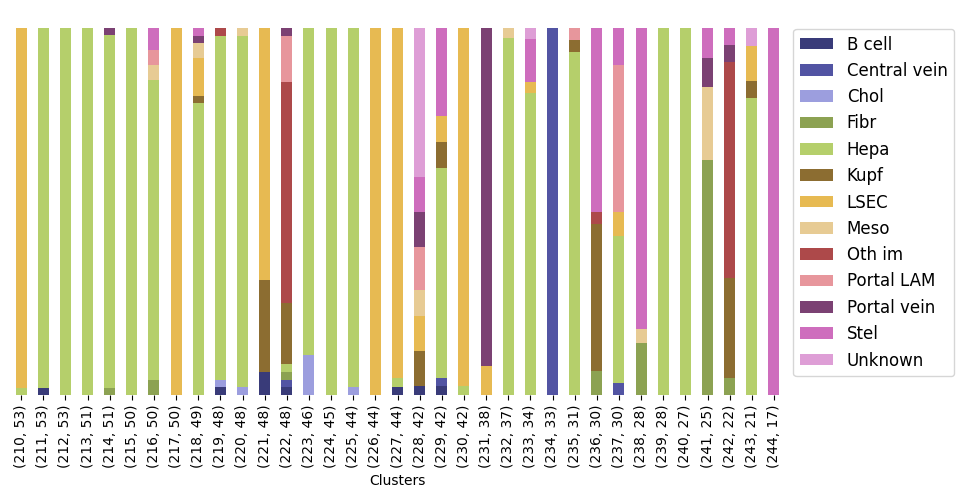

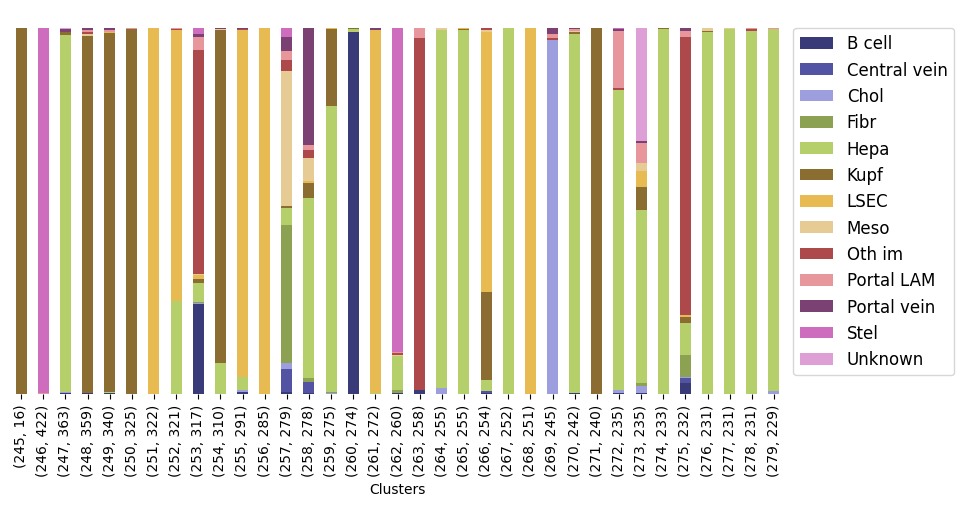

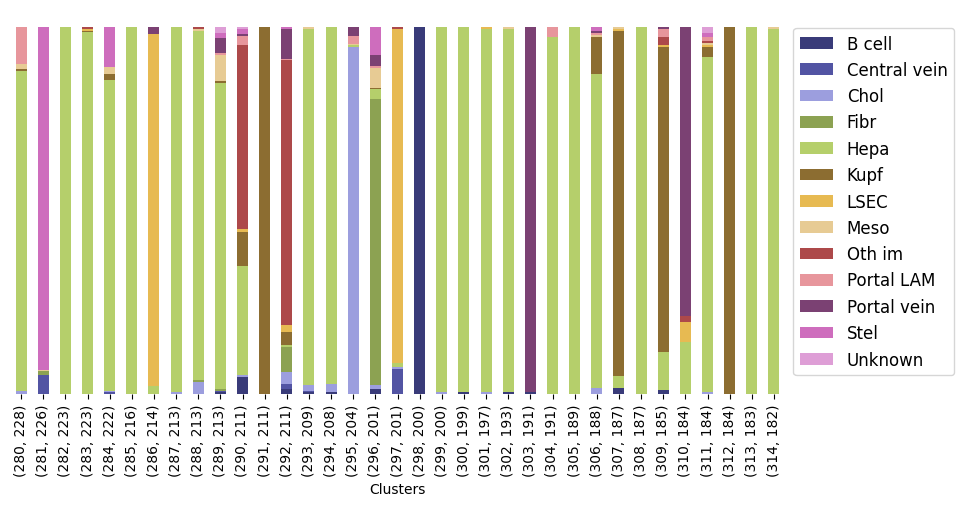

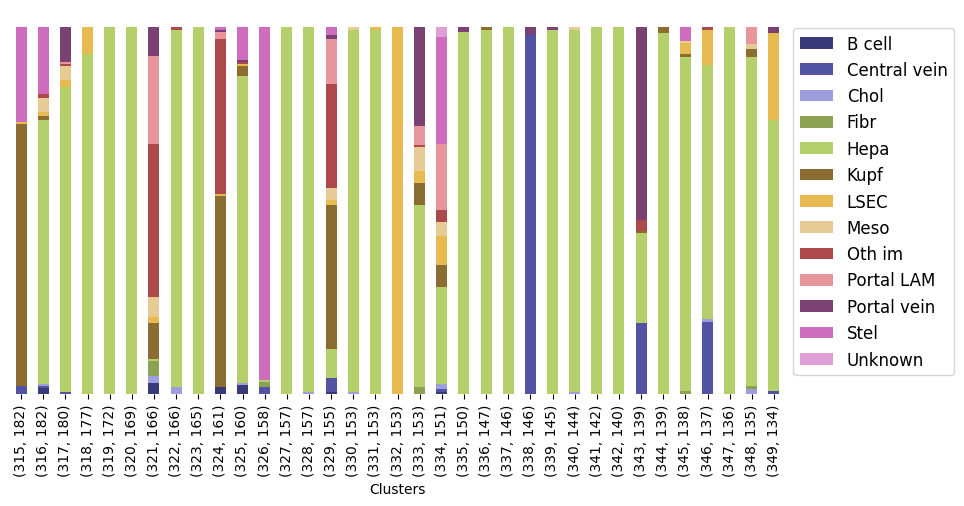

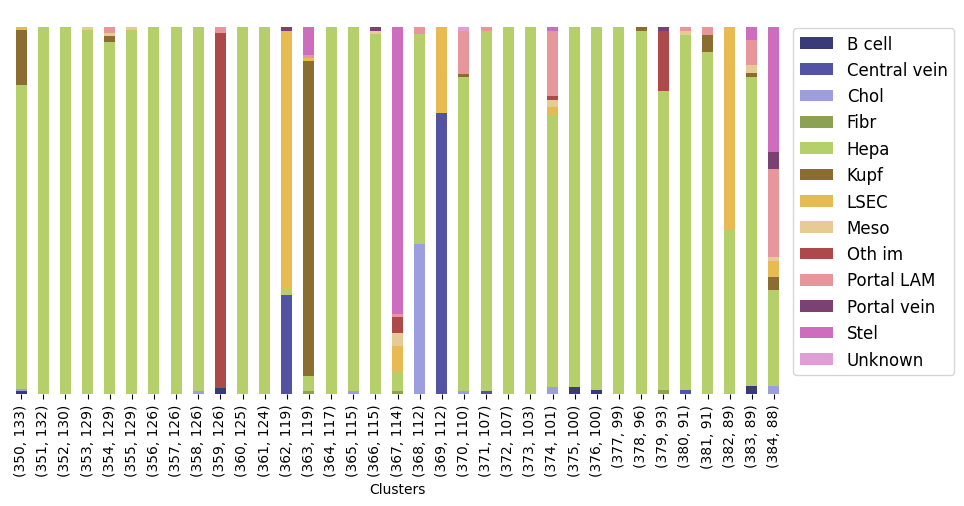

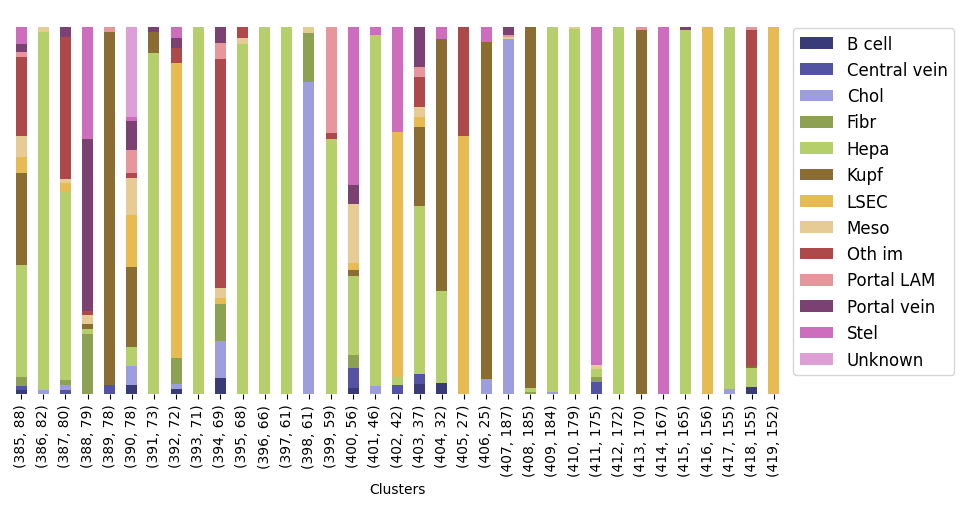

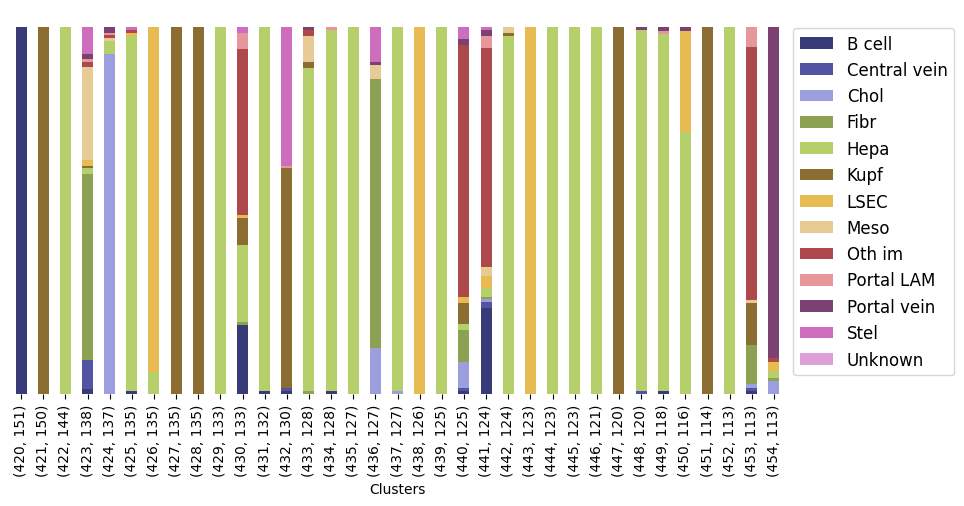

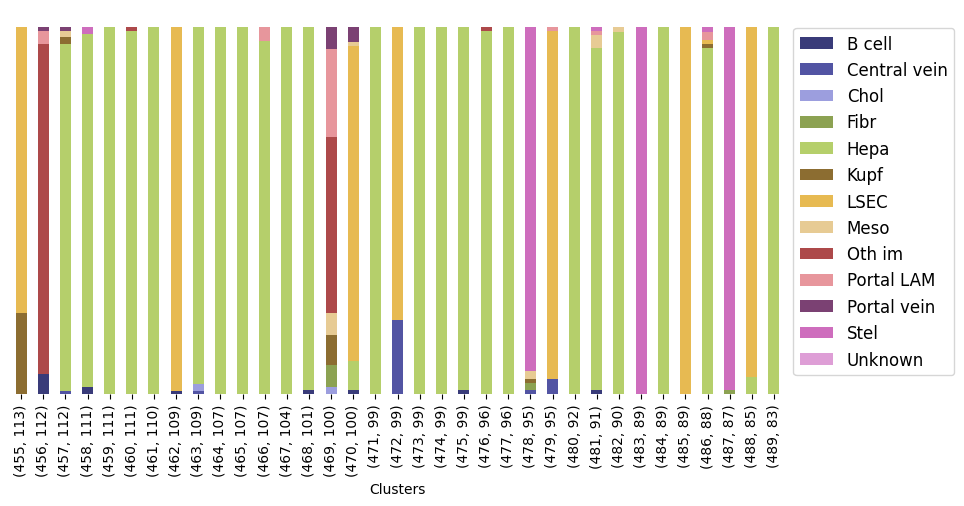

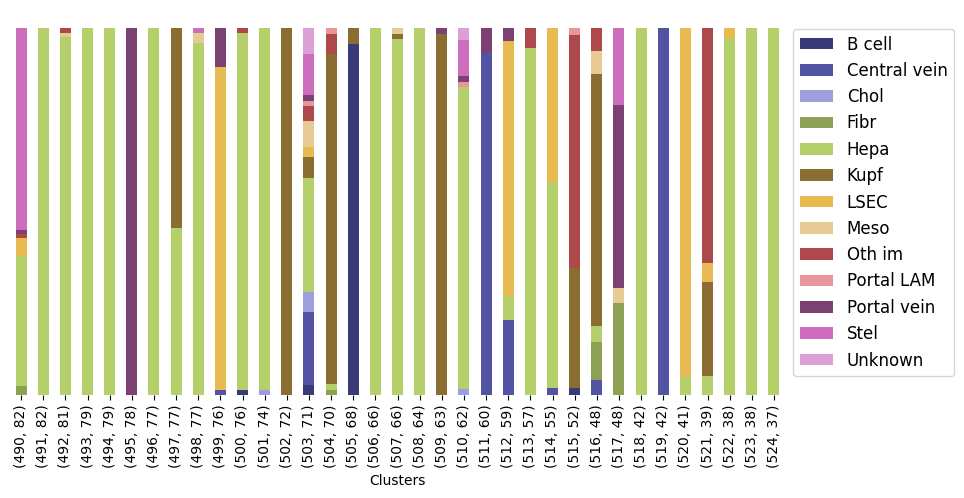

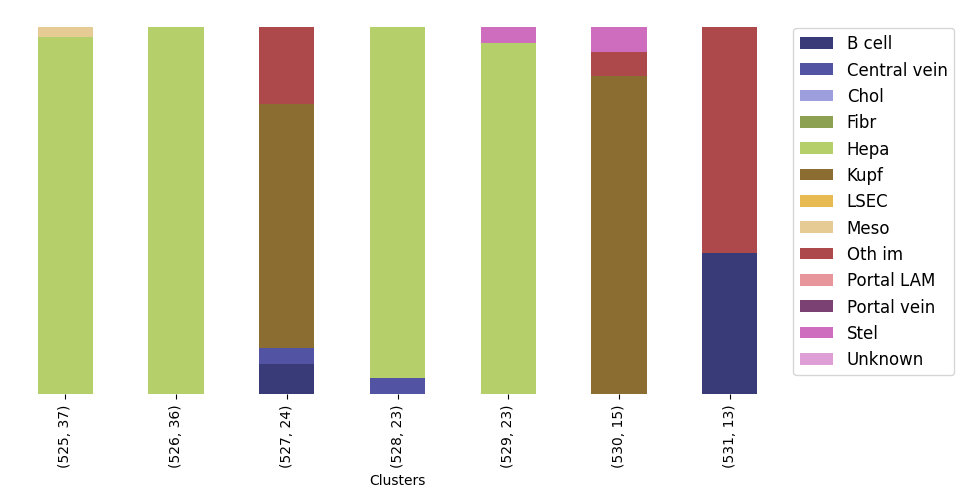

In [9]:
cell_types = anndata_samples_together.obs[annotation].unique().tolist()  
leiden_clusters_per_ct = clusteringVSleiden(anndata_samples_together,annotation,"leiden",cell_types=cell_types,print_results=True)

513 cells randomly sampled from each cell type in every iteration to do the DEG analysis
Summary:
Fibr
Maybe drop:[['Fn1', 'Hepa'], ['Fn1', 'Stel']]
Summary:
Fibr
Maybe drop:[['Fn1', 'Hepa'], ['Fn1', 'Stel']]
Summary:
Fibr
Maybe drop:[['Fn1', 'Hepa'], ['Fn1', 'Stel']]
0    1   
Fn1  Hepa    3
     Stel    3
dtype: int64


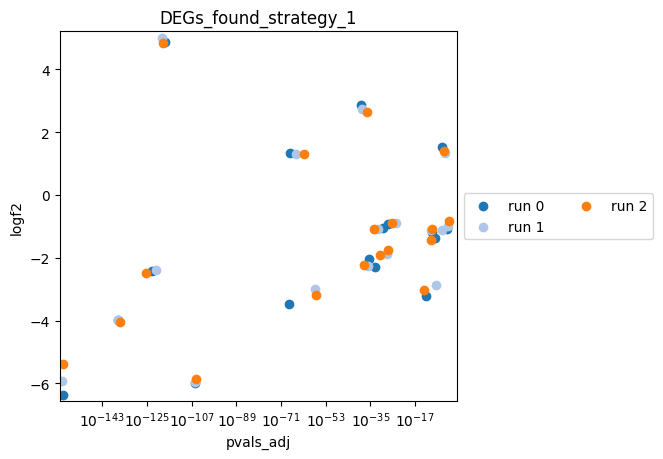

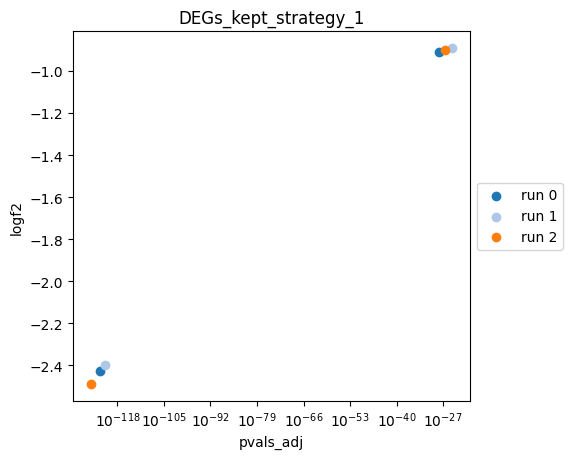

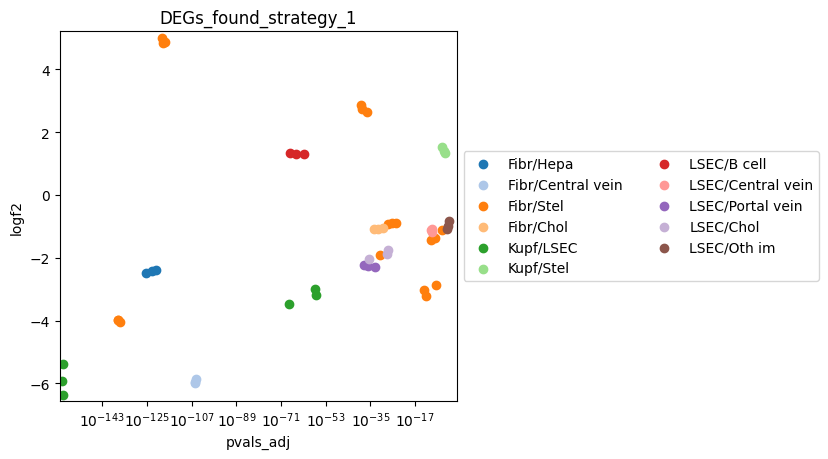

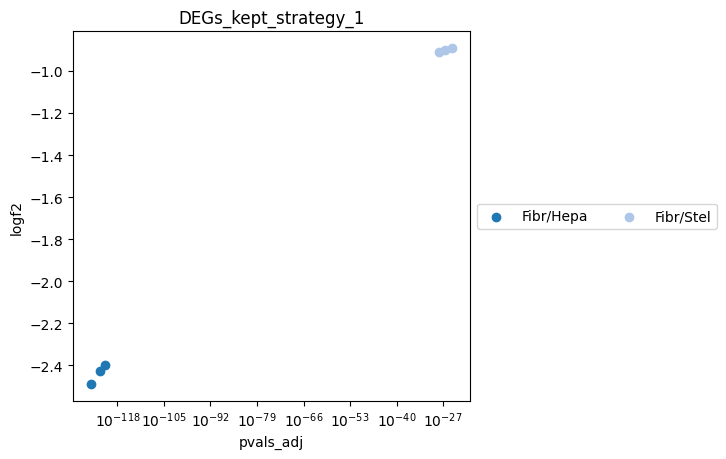

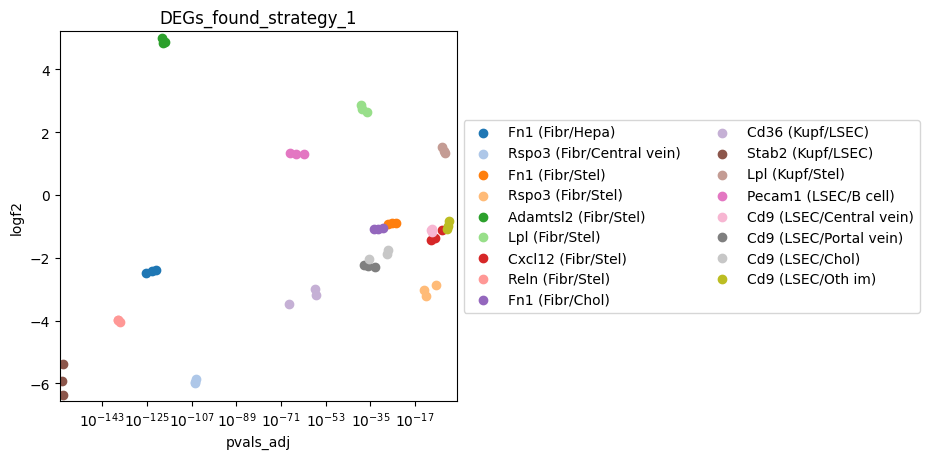

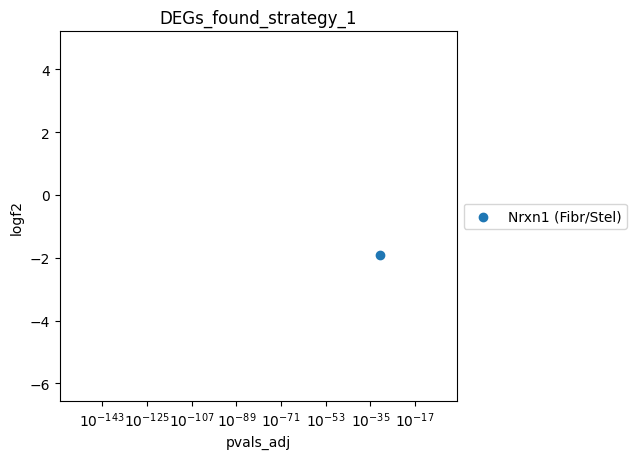

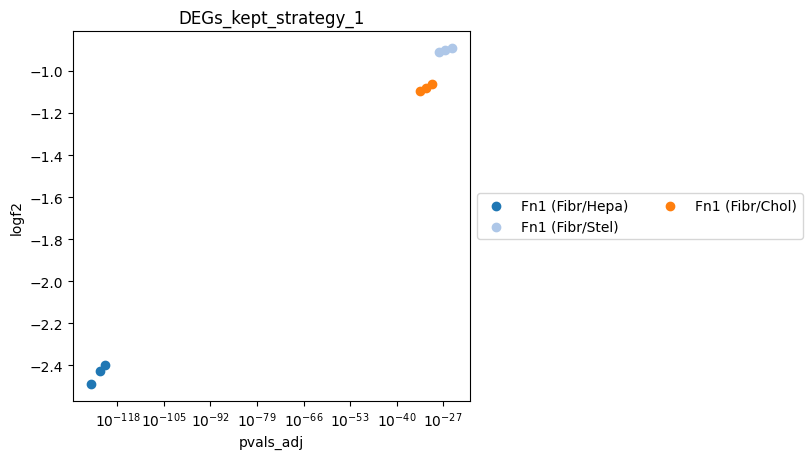

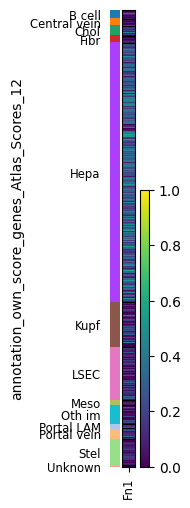

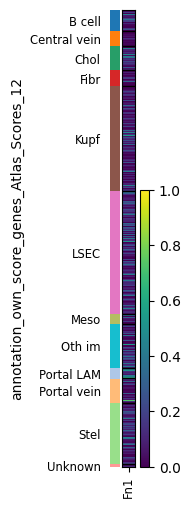

({'Fibr': [('Fn1', 'Hepa'), ('Fn1', 'Stel')]},
 {0: {'Fibr': [['Fn1', 'Hepa'],
    ['Fn1', 'Stel'],
    ['Fn1', 'Hepa'],
    ['Fn1', 'Stel'],
    ['Fn1', 'Hepa'],
    ['Fn1', 'Stel']]},
  1: {'Fibr': [['Fn1', 'Hepa'], ['Fn1', 'Stel']]},
  2: {'Fibr': [['Fn1', 'Hepa'], ['Fn1', 'Stel']]}},
 {0: {'Fibr_Hepa': {'DEGs':         gene       pval_adj      logf2   ct1   ct2
    0     Col1a1  3.519314e-164   7.497527  Fibr  Hepa
    1        Dpt  2.244465e-136   7.952490  Fibr  Hepa
    2   Adamtsl2  1.031019e-128  27.828318  Fibr  Hepa
    3        Dcn  2.705792e-116   5.215392  Fibr  Hepa
    4     Igfbp3  1.636498e-114   6.467858  Fibr  Hepa
    5     Pdgfrb   5.233927e-93   8.440719  Fibr  Hepa
    6        Axl   5.720543e-72   5.305603  Fibr  Hepa
    7     Pdgfra   1.196260e-69  10.007004  Fibr  Hepa
    8    Colec11   2.640684e-68   3.780909  Fibr  Hepa
    9        Lpl   9.066225e-53   4.580257  Fibr  Hepa
    10     Mfap4   1.905537e-42   8.452392  Fibr  Hepa
    11   Tmem119   3.114279

In [10]:
Apply_strategy_multiple_times(anndata_samples_together,annotation,path_mg,3,1,OUTPUT_DIR)